<a href="https://colab.research.google.com/github/snbaskarraj/Bigdata/blob/master/Copy_of_M1_NB_MiniProject_2_Structured_Data_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Advanced Certification Programme in AI and MLOps
## A programme by IISc and TalentSprint
### Mini-Project Notebook: Structured Data Classification

## Problem Statement

To predict whether a patient has a heart disease.

## Learning Objectives

At the end of the experiment, you will be able to

* Understand the Cleveland Clinic Foundation Heart Disease dataset
* Pre-process this dataset using Keras layers: IntegerLookup, StringLookup & Normalization
* Understand and use Keras concatenate layer
* Build a neural network model and architecture using Keras functional api
* Predict an unseen data

## Introduction

This example demonstrates how to do structured data classification, starting from a raw
CSV file. Our data includes both numerical and categorical features. We will use Keras
preprocessing layers to normalize the numerical features and vectorize the categorical
ones.

Note that this example should be run with TensorFlow 2.5 or higher.

## Dataset

[Our dataset](https://archive.ics.uci.edu/ml/datasets/heart+Disease) is provided by the
Cleveland Clinic Foundation for Heart Disease.
It's a CSV file with 303 rows. Each row contains information about a patient (a
**sample**), and each column describes an attribute of the patient (a **feature**). We
use the features to predict whether a patient has a heart disease (**binary
classification**).

Here's the description of each feature:
<br><br>

Column| Description| Feature Type
------------|--------------------|----------------------
Age | Age in years | Numerical
Sex | (1 = male; 0 = female) | Categorical
CP | Chest pain type (0, 1, 2, 3, 4) | Categorical
Trestbpd | Resting blood pressure (in mm Hg on admission) | Numerical
Chol | Serum cholesterol in mg/dl | Numerical
FBS | fasting blood sugar in 120 mg/dl (1 = true; 0 = false) | Categorical
RestECG | Resting electrocardiogram results (0, 1, 2) | Categorical
Thalach | Maximum heart rate achieved | Numerical
Exang | Exercise induced angina (1 = yes; 0 = no) | Categorical
Oldpeak | ST depression induced by exercise relative to rest | Numerical
Slope | Slope of the peak exercise ST segment | Numerical
CA | Number of major vessels (0-3) colored by fluoroscopy | Both numerical & categorical
Thal | 3 = normal; 6 = fixed defect; 7 = reversible defect | Categorical
Target | Diagnosis of heart disease (1 = true; 0 = false) | Target

<br><br>

In [2]:
#@title Download the data
!wget -qq https://cdn.iisc.talentsprint.com/AIandMLOps/Datasets/heart.csv
print("Data Downloaded Successfuly!!")

Data Downloaded Successfuly!!


## Grading = 10 Points

### Import Required Packages

In [3]:
import tensorflow as tf
import numpy as np
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import IntegerLookup     # Used in Feature processing
from tensorflow.keras.layers import Normalization     # Used in Feature processing
from tensorflow.keras.layers import StringLookup      # Used in Feature processing

# Part A

## Load the data and create batches [2 Marks]

### Load data into a Pandas dataframe

Hint:: pd.read_csv

In [4]:
file_url = "/content/heart.csv"
## YOUR CODE HERE
# Read the downloaded CSV file
data = pd.read_csv("heart.csv")




Check the shape of the dataset:

In [5]:
## YOUR CODE HERE
# Print the shape of the dataset
print("Shape of the dataset:", data.shape)

Shape of the dataset: (303, 14)


Check the preview of a few samples:

Hint:: head()

In [6]:
## YOUR CODE HERE
# Display the first few rows
print(data.head())

   age  sex  cp  trestbps  chol  fbs  restecg  thalach  exang  oldpeak  slope  \
0   63    1   1       145   233    1        2      150      0      2.3      3   
1   67    1   4       160   286    0        2      108      1      1.5      2   
2   67    1   4       120   229    0        2      129      1      2.6      2   
3   37    1   3       130   250    0        0      187      0      3.5      3   
4   41    0   2       130   204    0        2      172      0      1.4      1   

   ca        thal  target  
0   0       fixed       0  
1   3      normal       1  
2   2  reversible       0  
3   0      normal       0  
4   0      normal       0  


Draw some inference from the data. What does the target column indicate?

The last column, "target", indicates whether the patient has a heart disease (1) or not
(0).

### Split the data into a training and validation set

Hint:: Use .sample() method from Pandas.

Refer to link [here](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.sample.html)

Official reference from pandas for drop method [here](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.drop.html)

In [7]:
#split data into training and validation sets

# Sample 80% of the data # Split the dfor training
train_dataframe = data.sample(frac=0.8, random_state=0)

# Drop the samples that are in the training set from the original data to create the validation set
val_dataframe = data.drop(train_dataframe.index)

# Display the number of samples in the training and validation sets
print(
    "Using %d samples for training and %d for validation"
    % (len(train_dataframe), len(val_dataframe))
)

Using 242 samples for training and 61 for validation


### Converting into tensorflow dataset & creating batches

Generate `tf.data.Dataset` objects for each dataframe:

Each `Dataset` yields a tuple `(input, target)` where `input` is a dictionary of features
and `target` is the value `0` or `1`:

Refer [here](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#from_tensor_slices) to create the tuple using tensorflow.

In [8]:
import tensorflow as tf

def dataframe_to_dataset(dataframe):
    print("\nConverting DataFrame to TensorFlow Dataset...")

    # Separate the target variable from the features
    dataframe = dataframe.copy()
    labels = dataframe.pop("target")
    print("\nDataFrame after removing 'target' column:")
    print(dataframe.head())
    print("\nTarget values:")
    print(labels.head())

    # Convert the Pandas DataFrame and Series to TensorFlow tensors
    # Here's where the tuple (input, target) is formed
    ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
    print("\nTuple created (input, target) using TensorFlow.")

    # Shuffle and batch the dataset
    ds = ds.shuffle(buffer_size=len(dataframe))
    ds = ds.batch(32)  # This batch size can be adjusted based on the use case.
    ds = ds.prefetch(buffer_size=tf.data.AUTOTUNE)  # Enables asynchronous loading of data
    print("Shuffled, batched, and set prefetch for the dataset.")

    return ds

# Create TensorFlow datasets for training and validation
print("Creating training dataset...")
train_ds = dataframe_to_dataset(train_dataframe)
print("\nTraining dataset created.")

print("\nCreating validation dataset...")
val_ds = dataframe_to_dataset(val_dataframe)
print("\nValidation dataset created.")




Creating training dataset...

Converting DataFrame to TensorFlow Dataset...

DataFrame after removing 'target' column:
     age  sex  cp  trestbps  chol  fbs  restecg  thalach  exang  oldpeak  \
225   58    0   4       130   197    0        0      131      0      0.6   
152   45    1   4       142   309    0        2      147      1      0.0   
228   55    0   4       128   205    0        1      130      1      2.0   
201   43    1   4       115   303    0        0      181      0      1.2   
52    53    0   4       130   264    0        2      143      0      0.4   

     slope  ca        thal  
225      2   0      normal  
152      2   3  reversible  
228      2   1  reversible  
201      2   0      normal  
52       2   0      normal  

Target values:
225    0
152    1
228    1
201    0
52     0
Name: target, dtype: int64

Tuple created (input, target) using TensorFlow.
Shuffled, batched, and set prefetch for the dataset.

Training dataset created.

Creating validation dataset...



In [12]:
# Visualizing one datapoint from the formatted data
## YOUR CODE HERE
def display_one_datapoint(dataset, dataset_name):
    print(f"\nData from {dataset_name}:\n")

    # Extract one batch from the dataset
    for batch in dataset.take(1):
        inputs, target = batch

    # Extract the first datapoint from the batch
    input_data = {feature: values[0].numpy() for feature, values in inputs.items()}
    target_data = target[0].numpy()

    # Print the results
    print("Input Features:")
    for feature_name, value in input_data.items():
        print(f"{feature_name}: {value} (Data Type: {type(value)})")
    print(f"\nTarget: {target_data} (Data Type: {type(target_data)})\n")
    print("-" * 50)  # Separator line


# Visualize data from train_ds and val_ds
display_one_datapoint(train_ds, "train_ds")
display_one_datapoint(val_ds, "val_ds")




Data from train_ds:

Input Features:
age: 58 (Data Type: <class 'numpy.int64'>)
sex: 0 (Data Type: <class 'numpy.int64'>)
cp: 4 (Data Type: <class 'numpy.int64'>)
trestbps: 130 (Data Type: <class 'numpy.int64'>)
chol: 197 (Data Type: <class 'numpy.int64'>)
fbs: 0 (Data Type: <class 'numpy.int64'>)
restecg: 0 (Data Type: <class 'numpy.int64'>)
thalach: 131 (Data Type: <class 'numpy.int64'>)
exang: 0 (Data Type: <class 'numpy.int64'>)
oldpeak: 0.6 (Data Type: <class 'numpy.float64'>)
slope: 2 (Data Type: <class 'numpy.int64'>)
ca: 0 (Data Type: <class 'numpy.int64'>)
thal: b'normal' (Data Type: <class 'bytes'>)

Target: 0 (Data Type: <class 'numpy.int64'>)

--------------------------------------------------

Data from val_ds:

Input Features:
age: 67 (Data Type: <class 'numpy.int64'>)
sex: 1 (Data Type: <class 'numpy.int64'>)
cp: 4 (Data Type: <class 'numpy.int64'>)
trestbps: 160 (Data Type: <class 'numpy.int64'>)
chol: 286 (Data Type: <class 'numpy.int64'>)
fbs: 0 (Data Type: <class 'n

#### Create the batch of the datasets:

Refer [here](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#batch) to create a batch using tensorflow.

In [11]:
## YOUR CODE HERE  ## For train
## YOUR CODE HERE  ## For val
# Check for missing values in the train and validation dataframes
print("Missing values in train_dataframe:")
print(train_dataframe.isnull().sum())
print("\nMissing values in val_dataframe:")
print(val_dataframe.isnull().sum())

# Check unique value counts for each categorical feature
categorical_columns = ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'ca', 'thal']

print("\nUnique values in categorical columns in train_dataframe:")
for col in categorical_columns:
    print(f"{col}: {train_dataframe[col].unique()}")

print("\nUnique values in categorical columns in val_dataframe:")
for col in categorical_columns:
    print(f"{col}: {val_dataframe[col].unique()}")

# Fixing the thal values in the dataframe
def fix_thal_values(df):
    mapping = {
        'normal': 'normal',
        'reversible': 'reversible',
        'fixed': 'fixed',
        '1': 'type_1',
        '2': 'type_2'
    }
    df['thal'] = df['thal'].map(mapping)
    return df

train_dataframe = fix_thal_values(train_dataframe)
val_dataframe = fix_thal_values(val_dataframe)

# Re-create your tf.data.Dataset
train_ds = tf.data.Dataset.from_tensor_slices((dict(train_dataframe.drop('target', axis=1)), train_dataframe['target']))
val_ds = tf.data.Dataset.from_tensor_slices((dict(val_dataframe.drop('target', axis=1)), val_dataframe['target']))

# Setting the batch size
BATCH_SIZE = 32

# Rebatching the datasets with `drop_remainder=True`
train_ds = train_ds.batch(BATCH_SIZE, drop_remainder=True).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.batch(BATCH_SIZE, drop_remainder=True).prefetch(buffer_size=tf.data.AUTOTUNE)

print("\nRebatched the train and validation datasets with a batch size of", BATCH_SIZE)

# Display a few examples from the batched datasets
def display_batch_examples(dataset, dataset_name):
    print(f"\nExamples from {dataset_name}:\n")

    # Extract one batch from the dataset
    for inputs, targets in dataset.take(1):
        # Display only the first 5 examples from the batch
        for i in range(min(5, len(targets.numpy()))):
            input_data = {feature: values[i].numpy() for feature, values in inputs.items()}
            target_data = targets[i].numpy()

            print(f"Example {i + 1}:")
            for feature_name, value in input_data.items():
                print(f"{feature_name}: {value}")
            print(f"Target: {target_data}\n")
        print("-" * 50)  # Separator line

# Display data from batched train_ds and val_ds
display_batch_examples(train_ds, "batched train_ds")
display_batch_examples(val_ds, "batched val_ds")





Missing values in train_dataframe:
age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
target      0
dtype: int64

Missing values in val_dataframe:
age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
target      0
dtype: int64

Unique values in categorical columns in train_dataframe:
sex: [0 1]
cp: [4 3 2 1 0]
fbs: [0 1]
restecg: [0 2 1]
exang: [0 1]
slope: [2 1 3]
ca: [0 3 1 2]
thal: ['normal' 'reversible' 'fixed' '1' '2']

Unique values in categorical columns in val_dataframe:
sex: [1 0]
cp: [4 3 1 2 0]
fbs: [0 1]
restecg: [2 0 1]
exang: [1 0]
slope: [2 3 1]
ca: [3 0 2 1]
thal: ['normal' 'reversible' 'fixed']

Rebatched the train and validation datasets with a batch size of 32

Examples from batched train_ds:

Example 1:
age: 58

## Feature preprocessing with Keras layers [3 Marks]

Categorical Features Encoding

The following features are categorical features encoded as integers:

- `sex`
- `cp`
- `fbs`
- `restecg`
- `exang`
- `ca`

In [1]:
'''
import tensorflow as tf
from tensorflow.keras.layers import Input, CategoryEncoding
from tensorflow.keras.models import Model

# Define input layers
input_sex = Input(shape=(1,), name='sex', dtype=tf.int32)
input_cp = Input(shape=(1,), name='cp', dtype=tf.int32)
input_fbs = Input(shape=(1,), name='fbs', dtype=tf.int32)
input_restecg = Input(shape=(1,), name='restecg', dtype=tf.int32)
input_exang = Input(shape=(1,), name='exang', dtype=tf.int32)
input_ca = Input(shape=(1,), name='ca', dtype=tf.int32)

# Define One-Hot encoding layers using num_tokens
encoded_sex = CategoryEncoding(num_tokens=3, output_mode='binary')(input_sex)
encoded_cp = CategoryEncoding(num_tokens=6, output_mode='binary')(input_cp)
encoded_fbs = CategoryEncoding(num_tokens=3, output_mode='binary')(input_fbs)
encoded_restecg = CategoryEncoding(num_tokens=4, output_mode='binary')(input_restecg)
encoded_exang = CategoryEncoding(num_tokens=3, output_mode='binary')(input_exang)
encoded_ca = CategoryEncoding(num_tokens=5, output_mode='binary')(input_ca)

# Construct the model
model = Model(inputs=[input_sex, input_cp, input_fbs, input_restecg, input_exang, input_ca],
              outputs=[encoded_sex, encoded_cp, encoded_fbs, encoded_restecg, encoded_exang, encoded_ca])

model.summary()
'''
import tensorflow as tf
from tensorflow.keras.layers import Input, CategoryEncoding, Concatenate, Dense
from tensorflow.keras.models import Model

# Define input layers
input_sex = Input(shape=(1,), name='sex', dtype=tf.int32)
input_cp = Input(shape=(1,), name='cp', dtype=tf.int32)
input_fbs = Input(shape=(1,), name='fbs', dtype=tf.int32)
input_restecg = Input(shape=(1,), name='restecg', dtype=tf.int32)
input_exang = Input(shape=(1,), name='exang', dtype=tf.int32)
input_ca = Input(shape=(1,), name='ca', dtype=tf.int32)

# Define One-Hot encoding layers using num_tokens
encoded_sex = CategoryEncoding(num_tokens=3, output_mode='binary')(input_sex)
encoded_cp = CategoryEncoding(num_tokens=6, output_mode='binary')(input_cp)
encoded_fbs = CategoryEncoding(num_tokens=3, output_mode='binary')(input_fbs)
encoded_restecg = CategoryEncoding(num_tokens=4, output_mode='binary')(input_restecg)
encoded_exang = CategoryEncoding(num_tokens=3, output_mode='binary')(input_exang)
encoded_ca = CategoryEncoding(num_tokens=5, output_mode='binary')(input_ca)

# Concatenate the outputs of all encoding layers
merged = Concatenate()([
    encoded_sex, encoded_cp, encoded_fbs,
    encoded_restecg, encoded_exang, encoded_ca
])

# Add some dense layers
dense1 = Dense(128, activation='relu')(merged)
dense2 = Dense(64, activation='relu')(dense1)
output = Dense(1, activation='sigmoid')(dense2)  # Assuming binary classification

# Construct the model
model = Model(inputs=[input_sex, input_cp, input_fbs, input_restecg, input_exang, input_ca], outputs=output)

model.summary()




Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 sex (InputLayer)            [(None, 1)]                  0         []                            
                                                                                                  
 cp (InputLayer)             [(None, 1)]                  0         []                            
                                                                                                  
 fbs (InputLayer)            [(None, 1)]                  0         []                            
                                                                                                  
 restecg (InputLayer)        [(None, 1)]                  0         []                            
                                                                                              

We will encode these features using **one-hot encoding**. We have two options
here:

 - Use `CategoryEncoding()`, which requires knowing the range of input values
 and will throw an error on input outside the range.
 - Use `IntegerLookup()` which will build a lookup table for inputs and **reserve
 an output index for unkown input values**.

For this example, we want a simple solution that will handle out of range inputs
at inference, so we will use `IntegerLookup()`.

We also have a categorical feature encoded as a string: `thal`. We will create an
index of all possible features and encode output using the `StringLookup()` layer.

Create a function `encode_categorical_feature`, this function takes four parameters.
1. Feature to be encoded.
2. Name of the feature in the dataset.
3. Dataset containing the feature.
4. A boolean value wether the feature is string or not.

**Refer :** StringLookup [here](https://www.tensorflow.org/api_docs/python/tf/keras/layers/StringLookup) and IntegerLookup [here](https://www.tensorflow.org/api_docs/python/tf/keras/layers/IntegerLookup).

In [3]:
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import IntegerLookup, StringLookup

#@title Download the data
!wget -qq https://cdn.iisc.talentsprint.com/AIandMLOps/Datasets/heart.csv
print("Data Downloaded Successfully!")

# Read the downloaded CSV file
data = pd.read_csv("heart.csv")

# Display the first few rows
print(data.head())

def encode_categorical_feature(feature, name, dataset, is_string):
    # If the feature is a string, create a StringLookup layer which will turn strings into integer indices
    if is_string:
        index = StringLookup()
        # Prepare a Dataset that only yields our feature
        feature_ds = tf.data.Dataset.from_tensor_slices(dataset[name])
        feature_ds = feature_ds.map(lambda x: tf.expand_dims(x, -1))
        # Learn the set of possible string values and assign them a fixed integer index
        index.adapt(feature_ds)
        # Turn the string input into integer indices
        encoded_feature = index(feature)
    # If the feature is numeric, create a IntegerLookup layer which will turn integers into one-hot encoded values
    else:
        index = IntegerLookup(output_mode='binary')
        # Prepare a Dataset that only yields our feature
        feature_ds = tf.data.Dataset.from_tensor_slices(dataset[name])
        feature_ds = feature_ds.map(lambda x: tf.expand_dims(x, -1))
        # Learn the set of possible integer values
        index.adapt(feature_ds)
        # Turn the integer input into one-hot encoded values
        encoded_feature = index(feature)


    return encoded_feature


# Usage example:
feature_name = "thal"
is_string = True # Set to False for integer features
feature = tf.keras.Input(shape=(1,), dtype=tf.string if is_string else tf.int64, name=feature_name)
encoded_feature = encode_categorical_feature(feature, feature_name, data, is_string)
print(encoded_feature)





Data Downloaded Successfully!
   age  sex  cp  trestbps  chol  fbs  restecg  thalach  exang  oldpeak  slope  \
0   63    1   1       145   233    1        2      150      0      2.3      3   
1   67    1   4       160   286    0        2      108      1      1.5      2   
2   67    1   4       120   229    0        2      129      1      2.6      2   
3   37    1   3       130   250    0        0      187      0      3.5      3   
4   41    0   2       130   204    0        2      172      0      1.4      1   

   ca        thal  target  
0   0       fixed       0  
1   3      normal       1  
2   2  reversible       0  
3   0      normal       0  
4   0      normal       0  
KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.int64, name=None), name='string_lookup_2/Identity:0', description="created by layer 'string_lookup_2'")


### Numerical features Normalization
The following feature are continuous numerical features:

- `age`
- `trestbps`
- `chol`
- `thalach`
- `oldpeak`
- `slope`

For each of these features, we will use a `Normalization()` layer to make sure the mean
of each feature is 0 and its standard deviation is 1.


- Define a function `encode_numerical_feature` to apply featurewise normalization to numerical features.


Refer Normalization [here](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Normalization)

In [6]:
import tensorflow as tf
import pandas as pd

# Download the data
!wget -qq https://cdn.iisc.talentsprint.com/AIandMLOps/Datasets/heart.csv
print("Data Downloaded Successfully!")

# Read the downloaded CSV file into a pandas dataframe
data = pd.read_csv("heart.csv")
print("\nFirst 5 rows of data:\n", data.head())

# Convert the pandas dataframe to a tf.data.Dataset
def df_to_dataset(dataframe, shuffle=True, batch_size=32):
    dataframe = dataframe.copy()
    labels = dataframe.pop('target')
    ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
    if shuffle:
        ds = ds.shuffle(buffer_size=len(dataframe))
    ds = ds.batch(batch_size)
    return ds

batch_size = 5  # Just for demonstration purposes
dataset = df_to_dataset(data, batch_size=batch_size)
'''
# For encoding categorical features
def encode_categorical_feature(feature, name, dataset, is_string):
    if is_string:
        print(f"\nEncoding string feature: {name}")
        # Create a StringLookup layer which will turn strings into integer indices
        index = tf.keras.layers.StringLookup()

        # Prepare a Dataset that only yields our feature
        feature_ds = dataset.map(lambda x, y: x[name])
        feature_ds = feature_ds.map(lambda x: tf.expand_dims(x, -1))

        # Learn the set of possible string values and assign them a fixed integer index
        index.adapt(feature_ds)

        # Turn the string input into integer indices
        encoded_feature = index(feature)
    else:
        print(f"\nEncoding integer feature: {name}")
        # Create an IntegerLookup layer which will turn integers into integer indices
        index = tf.keras.layers.IntegerLookup()

        # Prepare a Dataset that only yields our feature
        feature_ds = dataset.map(lambda x, y: x[name])
        feature_ds = feature_ds.map(lambda x: tf.expand_dims(x, -1))

        # Learn the set of possible integer values and assign them a fixed integer index
        index.adapt(feature_ds)

        # Turn the integer input into integer indices
        encoded_feature = index(feature)

    return encoded_feature
  '''

# For encoding numerical features
def encode_numerical_feature(feature, name, dataset):
    print(f"\nNormalizing numerical feature: {name}")
    # Create a Normalization layer for our feature
    normalizer = tf.keras.layers.Normalization(axis=None)

    # Prepare a Dataset that only yields our feature
    feature_ds = dataset.map(lambda x, y: x[name])
    feature_ds = feature_ds.map(lambda x: tf.expand_dims(x, -1))

    # Learn the statistics of the data
    normalizer.adapt(feature_ds)

    # Normalize the input feature
    encoded_feature = normalizer(feature)

    return encoded_feature

# Assuming you have the dataset prepared as tf.data.Dataset object
feature_name = "age"
age = tf.keras.Input(shape=(1,), dtype=tf.float32, name=feature_name)
encoded_age = encode_numerical_feature(age, feature_name, dataset)




Data Downloaded Successfully!

First 5 rows of data:
    age  sex  cp  trestbps  chol  fbs  restecg  thalach  exang  oldpeak  slope  \
0   63    1   1       145   233    1        2      150      0      2.3      3   
1   67    1   4       160   286    0        2      108      1      1.5      2   
2   67    1   4       120   229    0        2      129      1      2.6      2   
3   37    1   3       130   250    0        0      187      0      3.5      3   
4   41    0   2       130   204    0        2      172      0      1.4      1   

   ca        thal  target  
0   0       fixed       0  
1   3      normal       1  
2   2  reversible       0  
3   0      normal       0  
4   0      normal       0  

Normalizing numerical feature: age


# Part B

## Building the model [4 Marks]

#### Need to instantiate a Keras tensor for all features
 Use keras Input() [method](https://keras.io/api/layers/core_layers/input/).
* Create a list of inputs to be fed to the model.
* This list consists of the features output from keras Input() method.
* These inputs include all the features.


In [1]:
from tensorflow.keras.layers import Input

# Define input tensors for categorical features encoded as integers
input_sex = Input(shape=(1,), name='sex')
input_cp = Input(shape=(1,), name='cp')
input_fbs = Input(shape=(1,), name='fbs')
input_restecg = Input(shape=(1,), name='restecg')
input_exang = Input(shape=(1,), name='exang')
input_ca = Input(shape=(1,), name='ca')
input_thal = Input(shape=(1,), name='thal')

# Define input tensors for categorical feature encoded as a string
input_categorical_string = Input(shape=(1,), name='categorical_string')

# Define input tensors for numerical features
input_age = Input(shape=(1,), name='age')
input_trestbps = Input(shape=(1,), name='trestbps')
input_chol = Input(shape=(1,), name='chol')
input_thalach = Input(shape=(1,), name='thalach')
input_oldpeak = Input(shape=(1,), name='oldpeak')
input_slope = Input(shape=(1,), name='slope')

# Create a list of all input tensors
all_inputs = [
    input_sex, input_cp, input_fbs, input_restecg, input_exang, input_ca, input_thal,
    input_categorical_string,
    input_age, input_trestbps, input_chol, input_thalach, input_oldpeak, input_slope
]

# Now, 'all_inputs' is a list containing all the input tensors for your model.


### Encoding above features
Use  "encode_categorical_feature" & "encode_numerical_feature" function on respective features that we defined above.

In [3]:
import tensorflow as tf
import pandas as pd

# Download the data
!wget -qq https://cdn.iisc.talentsprint.com/AIandMLOps/Datasets/heart.csv
print("Data Downloaded Successfully!")

# Read the downloaded CSV file into a pandas dataframe
data = pd.read_csv("heart.csv")
print("\nFirst 5 rows of data:\n", data.head())

# Convert the pandas dataframe to a tf.data.Dataset
def df_to_dataset(dataframe, shuffle=True, batch_size=32):
    dataframe = dataframe.copy()
    labels = dataframe.pop('target')
    ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
    if shuffle:
        ds = ds.shuffle(buffer_size=len(dataframe))
    ds = ds.batch(batch_size)
    return ds

batch_size = 5  # Just for demonstration purposes
dataset = df_to_dataset(data, batch_size=batch_size)

# For encoding categorical features
def encode_categorical_feature(feature, name, dataset, is_string):
    if is_string:
        print(f"\nEncoding string feature: {name}")
        index = tf.keras.layers.StringLookup()
        feature_ds = dataset.map(lambda x, y: x[name])
        feature_ds = feature_ds.map(lambda x: tf.expand_dims(x, -1))
        index.adapt(feature_ds)
        encoded_feature = index(feature)
    else:
        print(f"\nEncoding integer feature: {name}")
        index = tf.keras.layers.IntegerLookup()
        feature_ds = dataset.map(lambda x, y: x[name])
        feature_ds = feature_ds.map(lambda x: tf.expand_dims(x, -1))
        index.adapt(feature_ds)
        encoded_feature = index(feature)
    return encoded_feature

# For encoding numerical features
def encode_numerical_feature(feature, name, dataset):
    print(f"\nNormalizing numerical feature: {name}")
    normalizer = tf.keras.layers.Normalization(axis=None)
    feature_ds = dataset.map(lambda x, y: x[name])
    feature_ds = feature_ds.map(lambda x: tf.expand_dims(x, -1))
    normalizer.adapt(feature_ds)
    encoded_feature = normalizer(feature)
    return encoded_feature

# Integer categorical features
sex_encoded = encode_categorical_feature(input_sex, 'sex', dataset, False)
cp_encoded = encode_categorical_feature(input_cp, 'cp', dataset, False)
fbs_encoded = encode_categorical_feature(input_fbs, 'fbs', dataset, False)
restecg_encoded = encode_categorical_feature(input_restecg, 'restecg', dataset, False)
exang_encoded = encode_categorical_feature(input_exang, 'exang', dataset, False)
ca_encoded = encode_categorical_feature(input_ca, 'ca', dataset, False)

# String categorical features
thal_encoded = encode_categorical_feature(input_categorical_string, 'thal', dataset, True)

# Numerical features
age_encoded = encode_numerical_feature(input_age, 'age', dataset)
trestbps_encoded = encode_numerical_feature(input_trestbps, 'trestbps', dataset)
chol_encoded = encode_numerical_feature(input_chol, 'chol', dataset)
thalach_encoded = encode_numerical_feature(input_thalach, 'thalach', dataset)
oldpeak_encoded = encode_numerical_feature(input_oldpeak, 'oldpeak', dataset)
slope_encoded = encode_numerical_feature(input_slope, 'slope', dataset)



Data Downloaded Successfully!

First 5 rows of data:
    age  sex  cp  trestbps  chol  fbs  restecg  thalach  exang  oldpeak  slope  \
0   63    1   1       145   233    1        2      150      0      2.3      3   
1   67    1   4       160   286    0        2      108      1      1.5      2   
2   67    1   4       120   229    0        2      129      1      2.6      2   
3   37    1   3       130   250    0        0      187      0      3.5      3   
4   41    0   2       130   204    0        2      172      0      1.4      1   

   ca        thal  target  
0   0       fixed       0  
1   3      normal       1  
2   2  reversible       0  
3   0      normal       0  
4   0      normal       0  

Encoding integer feature: sex

Encoding integer feature: cp

Encoding integer feature: fbs

Encoding integer feature: restecg

Encoding integer feature: exang

Encoding integer feature: ca

Encoding string feature: thal

Normalizing numerical feature: age

Normalizing numerical feature: tr

##### Understanding the result of  encoder functions

In [4]:

sex_encoded = encode_categorical_feature(input_sex, 'sex', dataset, False)

sex_encoded


Encoding integer feature: sex


<KerasTensor: shape=(None, 1) dtype=int64 (created by layer 'integer_lookup_6')>

In [5]:

cp_encoded = encode_categorical_feature(input_cp, 'cp', dataset, False)

cp_encoded


Encoding integer feature: cp


<KerasTensor: shape=(None, 1) dtype=int64 (created by layer 'integer_lookup_7')>

### Using Functional API for building model
Build the three model architectures with 1, 2, and 3 hidden layers having different numbers of neurons. Train for each architecture and compare the train and the validation accuracy.

* These inputs will be passed to keras.model.
* Concatenate the encoded features using layers.concatenate()
* Add the Dense layers and compile the model.

In [5]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import pandas as pd

# Download the data
!wget -qq https://cdn.iisc.talentsprint.com/AIandMLOps/Datasets/heart.csv
print("Data Downloaded Successfully!")

# Read the downloaded CSV file into a pandas dataframe
data = pd.read_csv("heart.csv")
print("\nFirst 5 rows of data:\n", data.head())

# Split data into training and validation sets
# Sample 80% of the data for training
train_dataframe = data.sample(frac=0.8, random_state=0)

# Drop the samples that are in the training set from the original data to create the validation set
val_dataframe = data.drop(train_dataframe.index)

# Display the number of samples in the training and validation sets
print(
    "Using %d samples for training and %d for validation"
    % (len(train_dataframe), len(val_dataframe))
)

# Convert the pandas dataframe to a tf.data.Dataset
def df_to_dataset(dataframe, shuffle=True, batch_size=32):
    dataframe = dataframe.copy()
    labels = dataframe.pop('target')
    ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
    if shuffle:
        ds = ds.shuffle(buffer_size=len(dataframe))
    ds = ds.batch(batch_size)
    return ds

batch_size = 5  # Just for demonstration purposes
train_dataset = df_to_dataset(train_dataframe, batch_size=batch_size)
val_dataset = df_to_dataset(val_dataframe, shuffle=False, batch_size=batch_size)

# Define the input tensors for all features
sex = tf.keras.Input(shape=(1,), dtype=tf.float32, name="sex")
cp = tf.keras.Input(shape=(1,), dtype=tf.float32, name="cp")
fbs = tf.keras.Input(shape=(1,), dtype=tf.float32, name="fbs")
restecg = tf.keras.Input(shape=(1,), dtype=tf.float32, name="restecg")
exang = tf.keras.Input(shape=(1,), dtype=tf.float32, name="exang")
ca = tf.keras.Input(shape=(1,), dtype=tf.float32, name="ca")
thal = tf.keras.Input(shape=(1,), dtype=tf.string, name="thal")
age = tf.keras.Input(shape=(1,), dtype=tf.float32, name="age")
trestbps = tf.keras.Input(shape=(1,), dtype=tf.float32, name="trestbps")
chol = tf.keras.Input(shape=(1,), dtype=tf.float32, name="chol")
thalach = tf.keras.Input(shape=(1,), dtype=tf.float32, name="thalach")
oldpeak = tf.keras.Input(shape=(1,), dtype=tf.float32, name="oldpeak")
slope = tf.keras.Input(shape=(1,), dtype=tf.float32, name="slope")

# Define a function to encode categorical features
def encode_categorical_feature(feature, name, dataset, is_string):
    if is_string:
        index = tf.keras.layers.StringLookup()
    else:
        index = tf.keras.layers.IntegerLookup()
    feature_ds = dataset.map(lambda x, y: x[name])
    feature_ds = feature_ds.map(lambda x: tf.expand_dims(x, -1))
    index.adapt(feature_ds)
    encoded_feature = index(feature)
    return encoded_feature

# Define a function to encode numerical features
def encode_numerical_feature(feature, name, dataset):
    normalizer = tf.keras.layers.Normalization(axis=None)
    feature_ds = dataset.map(lambda x, y: x[name])
    feature_ds = feature_ds.map(lambda x: tf.expand_dims(x, -1))
    normalizer.adapt(feature_ds)
    encoded_feature = normalizer(feature)
    return encoded_feature

# Encode categorical and numerical features
sex_encoded = encode_categorical_feature(sex, 'sex', train_dataset, False)
cp_encoded = encode_categorical_feature(cp, 'cp', train_dataset, False)
fbs_encoded = encode_categorical_feature(fbs, 'fbs', train_dataset, False)
restecg_encoded = encode_categorical_feature(restecg, 'restecg', train_dataset, False)
exang_encoded = encode_categorical_feature(exang, 'exang', train_dataset, False)
ca_encoded = encode_categorical_feature(ca, 'ca', train_dataset, False)
thal_encoded = encode_categorical_feature(thal, 'thal', train_dataset, True)
age_encoded = encode_numerical_feature(age, 'age', train_dataset)
trestbps_encoded = encode_numerical_feature(trestbps, 'trestbps', train_dataset)
chol_encoded = encode_numerical_feature(chol, 'chol', train_dataset)
thalach_encoded = encode_numerical_feature(thalach, 'thalach', train_dataset)
oldpeak_encoded = encode_numerical_feature(oldpeak, 'oldpeak', train_dataset)
slope_encoded = encode_numerical_feature(slope, 'slope', train_dataset)

# Convert integer encoded tensors to float32
sex_encoded = tf.keras.layers.Rescaling(1.0 / (2 - 1))(sex_encoded)
cp_encoded = tf.keras.layers.Rescaling(1.0 / (4 - 1))(cp_encoded)
fbs_encoded = tf.keras.layers.Rescaling(1.0 / (2 - 1))(fbs_encoded)
restecg_encoded = tf.keras.layers.Rescaling(1.0 / (3 - 1))(restecg_encoded)
exang_encoded = tf.keras.layers.Rescaling(1.0 / (2 - 1))(exang_encoded)
ca_encoded = tf.keras.layers.Rescaling(1.0 / (5 - 1))(ca_encoded)
thal_encoded = tf.keras.layers.Rescaling(1.0 / (4 - 1))(thal_encoded)

# Define the feature inputs
all_inputs = [
    sex, cp, fbs, restecg, exang, ca, thal, age, trestbps, chol, thalach, oldpeak, slope
]

# Concatenate the encoded features
all_features = layers.concatenate([
    sex_encoded, cp_encoded, fbs_encoded, restecg_encoded, exang_encoded, ca_encoded,
    thal_encoded, age_encoded, trestbps_encoded, chol_encoded, thalach_encoded,
    oldpeak_encoded, slope_encoded
])

# Define the architecture for the model with 1 hidden layer
x = layers.Dense(64, activation="relu")(all_features)
x = layers.Dropout(0.2)(x)
output = layers.Dense(1, activation="sigmoid")(x)

# Create and compile the model with 1 hidden layer
model_1_hidden = keras.Model(inputs=all_inputs, outputs=output)
model_1_hidden.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

# Train the model with your data
# Replace X_train and y_train with your actual training data
history_1_hidden = model_1_hidden.fit(train_dataset, epochs=10, validation_data=val_dataset)

# Print training and validation accuracy for the 1-hidden-layer model
train_accuracy_1_hidden = history_1_hidden.history["accuracy"][-1]
val_accuracy_1_hidden = history_1_hidden.history["val_accuracy"][-1]
print(f"Model with 1 hidden layer - Training accuracy: {train_accuracy_1_hidden}, Validation accuracy: {val_accuracy_1_hidden}")

# Define the architecture for the model with 2 hidden layers
x = layers.Dense(64, activation="relu")(all_features)
x = layers.Dropout(0.2)(x)
x = layers.Dense(32, activation="relu")(x)
x = layers.Dropout(0.2)(x)
output = layers.Dense(1, activation="sigmoid")(x)

# Create and compile the model with 2 hidden layers
model_2_hidden = keras.Model(inputs=all_inputs, outputs=output)
model_2_hidden.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

# Train the model with your data
# Replace X_train and y_train with your actual training data
history_2_hidden = model_2_hidden.fit(train_dataset, epochs=10, validation_data=val_dataset)

# Print training and validation accuracy for the 2-hidden-layer model
train_accuracy_2_hidden = history_2_hidden.history["accuracy"][-1]
val_accuracy_2_hidden = history_2_hidden.history["val_accuracy"][-1]
print(f"Model with 2 hidden layers - Training accuracy: {train_accuracy_2_hidden}, Validation accuracy: {val_accuracy_2_hidden}")

# Define the architecture for the model with 3 hidden layers
x = layers.Dense(64, activation="relu")(all_features)
x = layers.Dropout(0.2)(x)
x = layers.Dense(32, activation="relu")(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(16, activation="relu")(x)
x = layers.Dropout(0.2)(x)
output = layers.Dense(1, activation="sigmoid")(x)

# Create and compile the model with 3 hidden layers
model_3_hidden = keras.Model(inputs=all_inputs, outputs=output)
model_3_hidden.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

# Train the model with your data
# Replace X_train and y_train with your actual training data
history_3_hidden = model_3_hidden.fit(train_dataset, epochs=10, validation_data=val_dataset)

# Print training and validation accuracy for the 3-hidden-layer model
train_accuracy_3_hidden = history_3_hidden.history["accuracy"][-1]
val_accuracy_3_hidden = history_3_hidden.history["val_accuracy"][-1]
print(f"Model with 3 hidden layers - Training accuracy: {train_accuracy_3_hidden}, Validation accuracy: {val_accuracy_3_hidden}")





Data Downloaded Successfully!

First 5 rows of data:
    age  sex  cp  trestbps  chol  fbs  restecg  thalach  exang  oldpeak  slope  \
0   63    1   1       145   233    1        2      150      0      2.3      3   
1   67    1   4       160   286    0        2      108      1      1.5      2   
2   67    1   4       120   229    0        2      129      1      2.6      2   
3   37    1   3       130   250    0        0      187      0      3.5      3   
4   41    0   2       130   204    0        2      172      0      1.4      1   

   ca        thal  target  
0   0       fixed       0  
1   3      normal       1  
2   2  reversible       0  
3   0      normal       0  
4   0      normal       0  
Using 242 samples for training and 61 for validation
Epoch 1/10
49/49 [==============================] - 6s 11ms/step - loss: 0.5829 - accuracy: 0.7149 - val_loss: 0.5003 - val_accuracy: 0.8033
Epoch 2/10
49/49 [==============================] - 0s 6ms/step - loss: 0.4762 - accuracy: 0.8017

### Visualize the connectivity graph using `keras.utils.plot_model`:

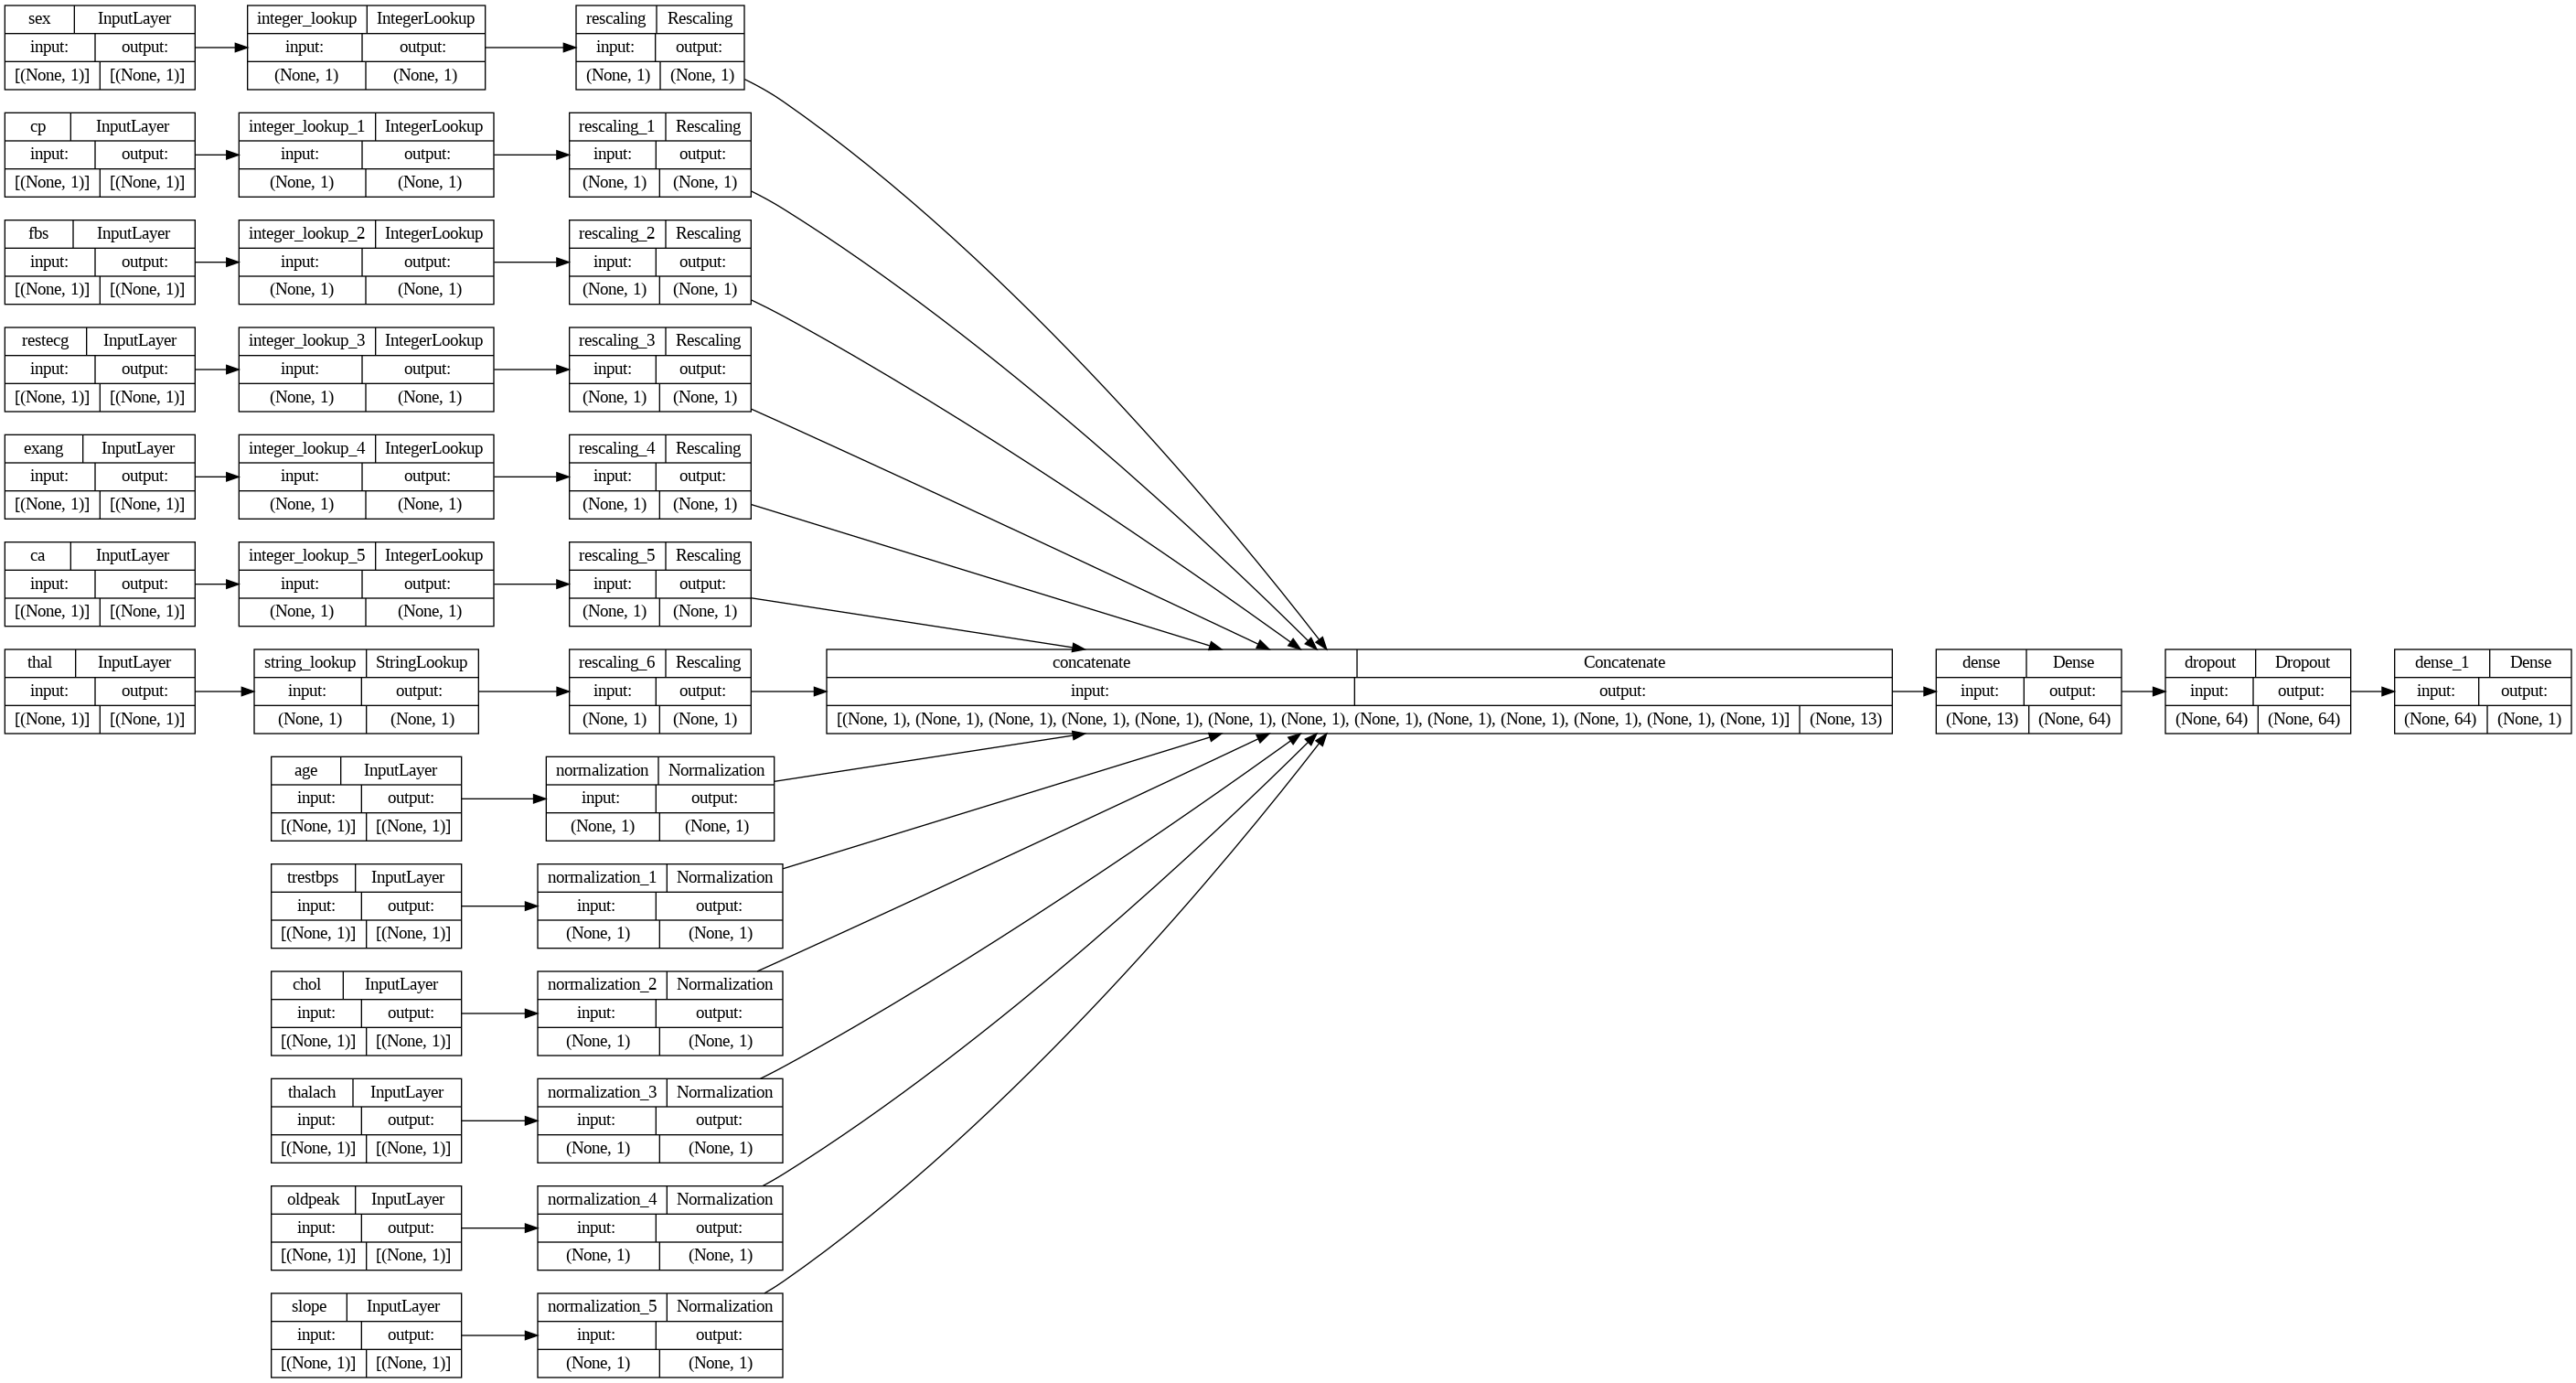

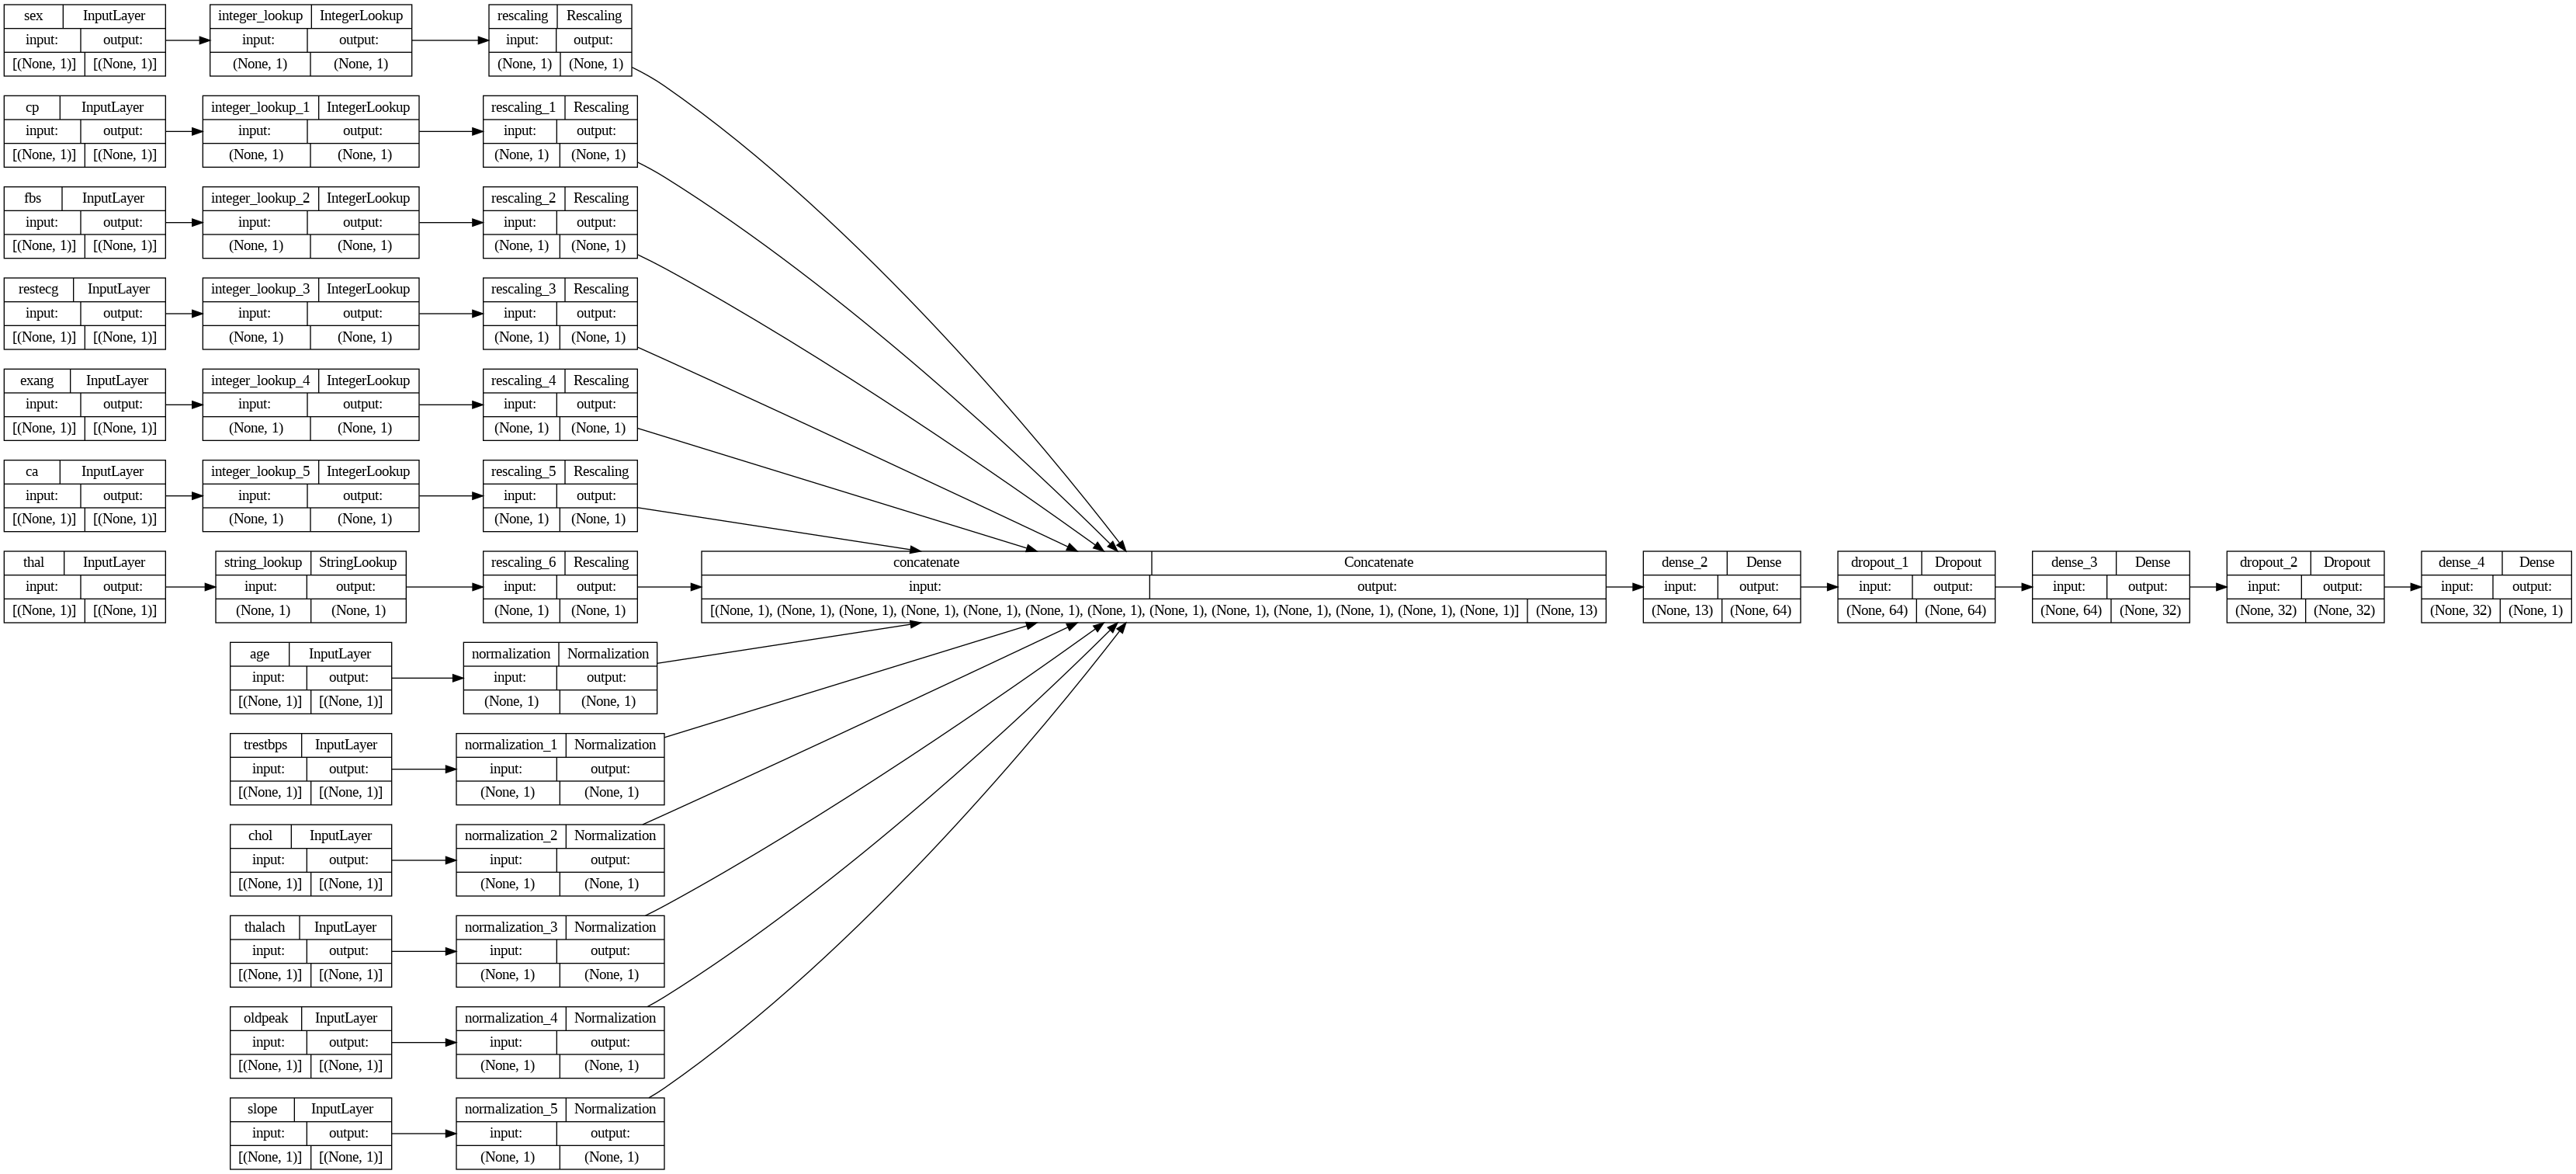

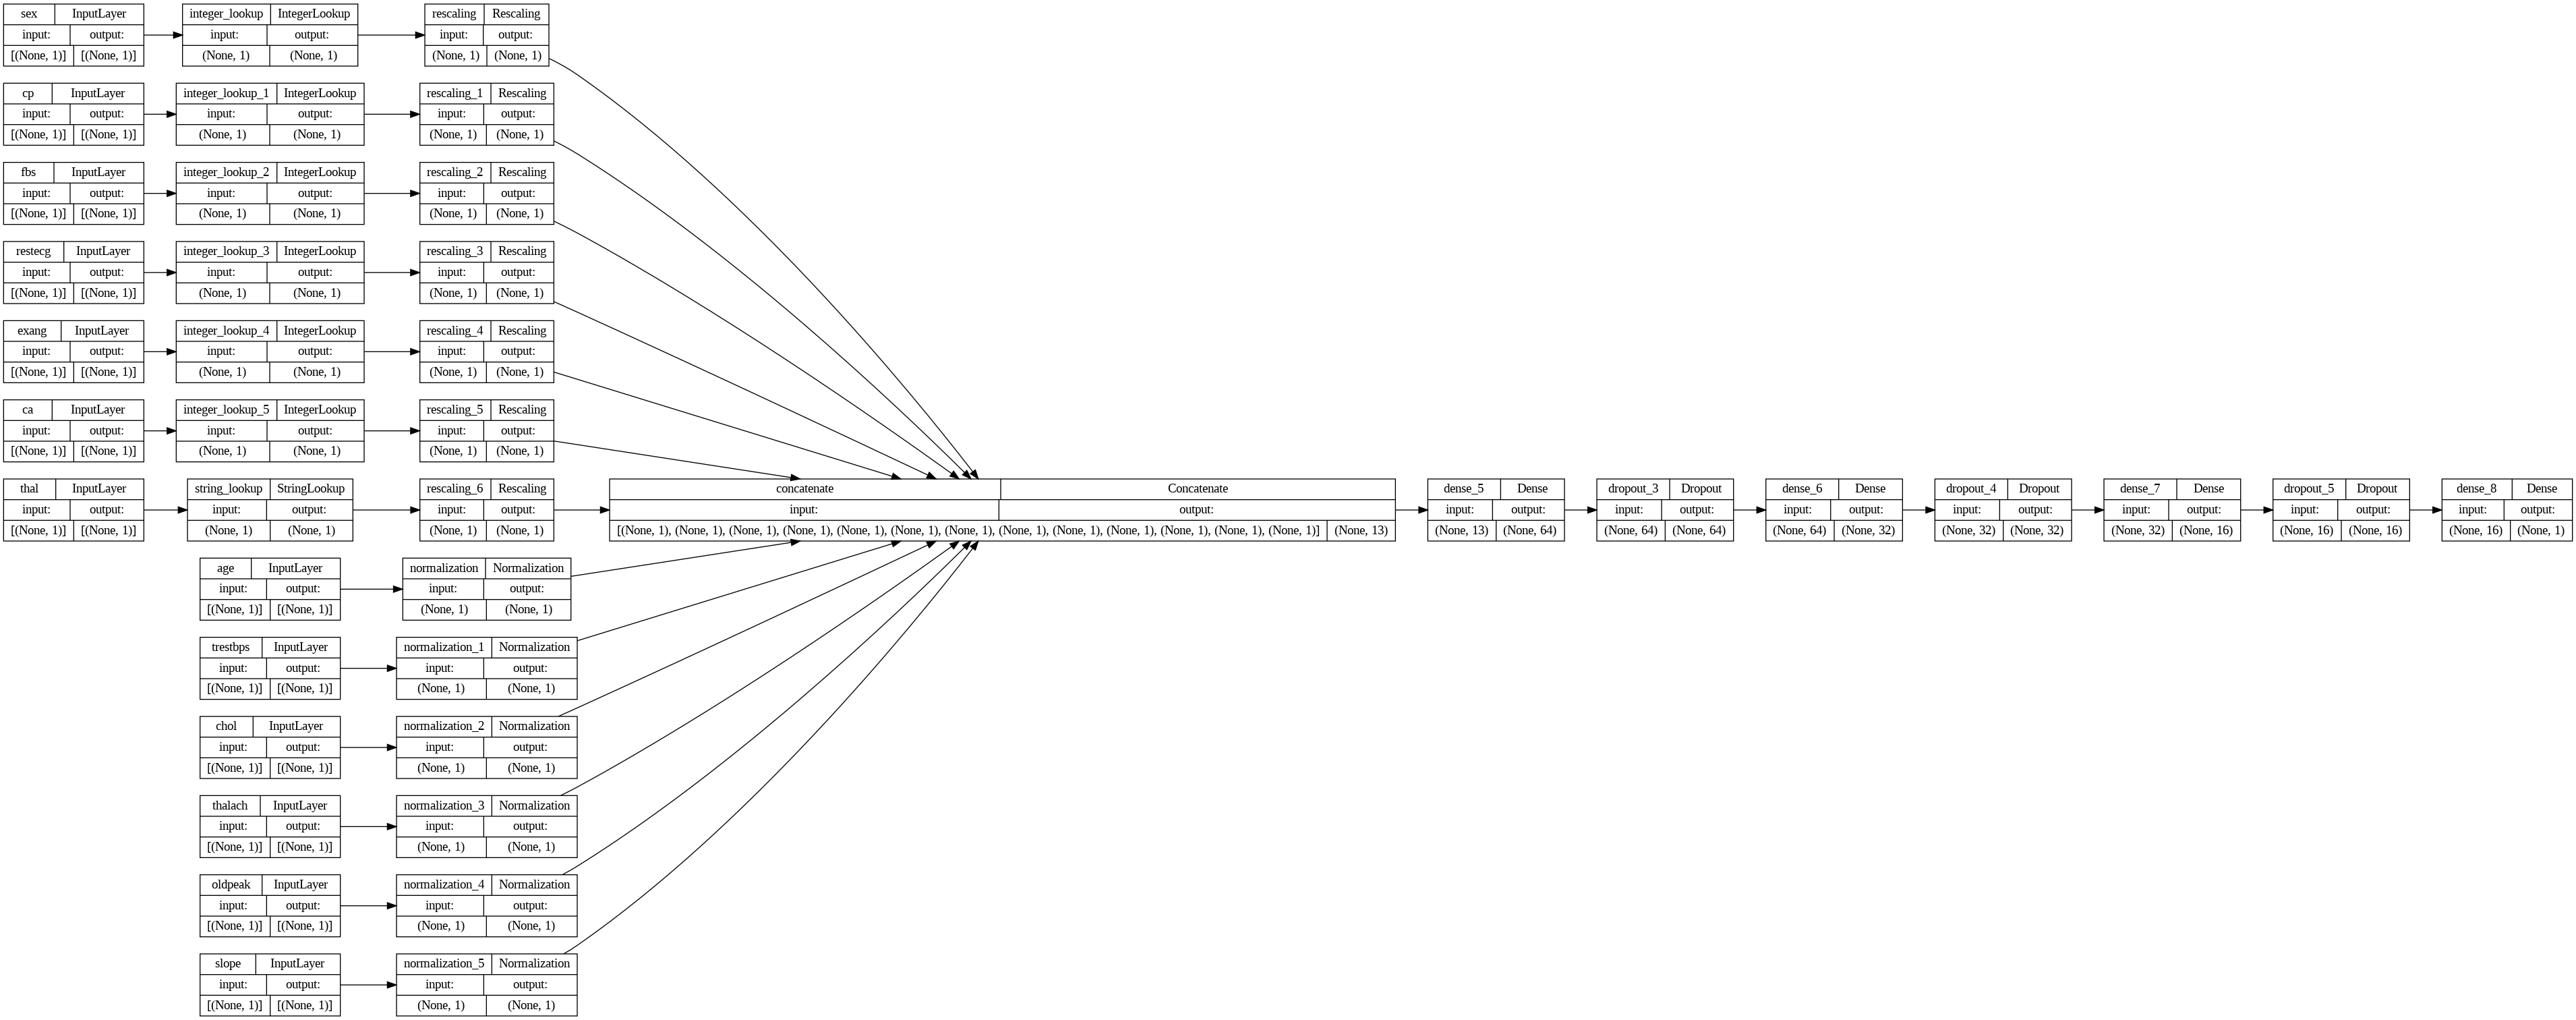

In [7]:
# `rankdir='LR'` is to make the graph horizontal.
## YOUR CODE HERE
# `rankdir='LR'` is to make the graph horizontal.
from tensorflow.keras.utils import plot_model
from IPython.display import Image, display

# Define a list of models
models = [model_1_hidden, model_2_hidden, model_3_hidden]

# Visualize each model and display them
for i, model in enumerate(models, start=1):
    plot_model(model, show_shapes=True, rankdir='LR', to_file=f'model_{i}_hidden.png')
    display(Image(filename=f'model_{i}_hidden.png'))




### Train the model

In [9]:
## YOUR CODE HERE
# Train the model with 1 hidden layer
history_1_hidden = model_1_hidden.fit(train_dataset, epochs=10, validation_data=val_dataset)

# Save the model with 1 hidden layer using the TensorFlow native format
model_1_hidden.save("model_1_hidden", save_format="tf")

# Evaluate and print the accuracy of the 1-hidden-layer model
train_accuracy_1_hidden = history_1_hidden.history['accuracy'][-1]
val_accuracy_1_hidden = history_1_hidden.history['val_accuracy'][-1]
print(f"Model with 1 hidden layer - Training accuracy: {train_accuracy_1_hidden:.4f}, Validation accuracy: {val_accuracy_1_hidden:.4f}")

# Train the model with 2 hidden layers
history_2_hidden = model_2_hidden.fit(train_dataset, epochs=10, validation_data=val_dataset)

# Save the model with 2 hidden layers using the TensorFlow native format
model_2_hidden.save("model_2_hidden", save_format="tf")

# Evaluate and print the accuracy of the 2-hidden-layer model
train_accuracy_2_hidden = history_2_hidden.history['accuracy'][-1]
val_accuracy_2_hidden = history_2_hidden.history['val_accuracy'][-1]
print(f"Model with 2 hidden layers - Training accuracy: {train_accuracy_2_hidden:.4f}, Validation accuracy: {val_accuracy_2_hidden:.4f}")

# Train the model with 3 hidden layers
history_3_hidden = model_3_hidden.fit(train_dataset, epochs=10, validation_data=val_dataset)

# Save the model with 3 hidden layers using the TensorFlow native format
model_3_hidden.save("model_3_hidden", save_format="tf")

# Evaluate and print the accuracy of the 3-hidden-layer model
train_accuracy_3_hidden = history_3_hidden.history['accuracy'][-1]
val_accuracy_3_hidden = history_3_hidden.history['val_accuracy'][-1]
print(f"Model with 3 hidden layers - Training accuracy: {train_accuracy_3_hidden:.4f}, Validation accuracy: {val_accuracy_3_hidden:.4f}")

# Determine the best model based on validation accuracy
best_model = None
best_val_accuracy = max(val_accuracy_1_hidden, val_accuracy_2_hidden, val_accuracy_3_hidden)
if best_val_accuracy == val_accuracy_1_hidden:
    best_model = model_1_hidden
    best_model_name = "1 hidden layer"
elif best_val_accuracy == val_accuracy_2_hidden:
    best_model = model_2_hidden
    best_model_name = "2 hidden layers"
else:
    best_model = model_3_hidden
    best_model_name = "3 hidden layers"

print(f"The best model is the one with {best_model_name} and validation accuracy: {best_val_accuracy:.4f}")




Epoch 1/10
49/49 [==============================] - 0s 6ms/step - loss: 0.3183 - accuracy: 0.8595 - val_loss: 0.4471 - val_accuracy: 0.8033
Epoch 2/10
49/49 [==============================] - 0s 8ms/step - loss: 0.3112 - accuracy: 0.8430 - val_loss: 0.4475 - val_accuracy: 0.7869
Epoch 3/10
49/49 [==============================] - 1s 11ms/step - loss: 0.2911 - accuracy: 0.8678 - val_loss: 0.4472 - val_accuracy: 0.7869
Epoch 4/10
49/49 [==============================] - 1s 12ms/step - loss: 0.2954 - accuracy: 0.8678 - val_loss: 0.4444 - val_accuracy: 0.7869
Epoch 5/10
49/49 [==============================] - 1s 13ms/step - loss: 0.2852 - accuracy: 0.8760 - val_loss: 0.4441 - val_accuracy: 0.7869
Epoch 6/10
49/49 [==============================] - 1s 13ms/step - loss: 0.2896 - accuracy: 0.8926 - val_loss: 0.4428 - val_accuracy: 0.7869
Epoch 7/10
49/49 [==============================] - 0s 6ms/step - loss: 0.3062 - accuracy: 0.8636 - val_loss: 0.4426 - val_accuracy: 0.7869
Epoch 8/10
49/49

## Inference on new data [1 Mark]

To get a prediction for a new sample, you can simply call `model.predict()`. There are
just two things you need to do:

1. wrap scalars into a list so as to have a batch dimension (models only process batches
of data, not single samples)
2. Call `convert_to_tensor` on each feature

Note : The predicted output should be either 0  or 1 based on a threshold value of probability 0.5.

In [17]:
## YOUR CODE HERE

#input_dict = {name: tf.convert_to_tensor([value]) for name, value in sample.items()}
#predictions = model.predict(input_dict)

## YOUR CODE HERE
import pandas as pd
import tensorflow as tf
from tensorflow import keras

# Load the models with the TensorFlow native format
model_1_hidden = keras.models.load_model("model_1_hidden", compile=False)
model_2_hidden = keras.models.load_model("model_2_hidden", compile=False)
model_3_hidden = keras.models.load_model("model_3_hidden", compile=False)

# Download the data
!wget -qq https://cdn.iisc.talentsprint.com/AIandMLOps/Datasets/heart.csv
print("Data Downloaded Successfully!")

# Read the downloaded CSV file into a pandas dataframe
data = pd.read_csv("heart.csv")
print("\nFirst 5 rows of data:\n", data.head())

# Sample data for inference (use the first 10 rows of the dataset)
sample_data = data.head(10).to_dict(orient="records")

# Models
models = [model_1_hidden, model_2_hidden, model_3_hidden]

# Inference for each model
for i, model in enumerate(models):
    print(f'Inference for Model with {i+1} Hidden Layer(s):')

    for j, sample in enumerate(sample_data):
        # Convert sample dictionary to input tensors
        input_dict = {name: tf.convert_to_tensor([value]) for name, value in sample.items()}

        # Predict using the model
        predictions = model.predict(input_dict)

        # Apply a threshold of 0.5 to get the final binary prediction (0 or 1)
        binary_prediction = (predictions > 0.5).astype(int)[0][0]

        print(f'Sample {j+1} - Predicted Probability: {predictions[0][0]}')
        print(f'Sample {j+1} - Binary Prediction (0 or 1): {binary_prediction}')

    print()


Data Downloaded Successfully!

First 5 rows of data:
    age  sex  cp  trestbps  chol  fbs  restecg  thalach  exang  oldpeak  slope  \
0   63    1   1       145   233    1        2      150      0      2.3      3   
1   67    1   4       160   286    0        2      108      1      1.5      2   
2   67    1   4       120   229    0        2      129      1      2.6      2   
3   37    1   3       130   250    0        0      187      0      3.5      3   
4   41    0   2       130   204    0        2      172      0      1.4      1   

   ca        thal  target  
0   0       fixed       0  
1   3      normal       1  
2   2  reversible       0  
3   0      normal       0  
4   0      normal       0  
Inference for Model with 1 Hidden Layer(s):
1/1 [==============================] - 0s 196ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:639: UserWarning: Input dict contained keys ['target'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


Sample 1 - Predicted Probability: 0.2899590730667114
Sample 1 - Binary Prediction (0 or 1): 0
1/1 [==============================] - 0s 30ms/step
Sample 2 - Predicted Probability: 0.8281635642051697
Sample 2 - Binary Prediction (0 or 1): 1
1/1 [==============================] - 0s 35ms/step
Sample 3 - Predicted Probability: 0.8039649724960327
Sample 3 - Binary Prediction (0 or 1): 1
1/1 [==============================] - 0s 31ms/step
Sample 4 - Predicted Probability: 0.2211531549692154
Sample 4 - Binary Prediction (0 or 1): 0
1/1 [==============================] - 0s 27ms/step
Sample 5 - Predicted Probability: 0.0055715362541377544
Sample 5 - Binary Prediction (0 or 1): 0
1/1 [==============================] - 0s 28ms/step
Sample 6 - Predicted Probability: 0.006922543980181217
Sample 6 - Binary Prediction (0 or 1): 0
1/1 [==============================] - 0s 28ms/step
Sample 7 - Predicted Probability: 0.7668353915214539
Sample 7 - Binary Prediction (0 or 1): 1
1/1 [====================